In [1]:
from typing import List, Tuple
import getpass
import numpy as np
from mnist import MNIST
from skimage.util.shape import view_as_windows
import math
from IPython.display import clear_output
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Sampler
from qiskit.circuit import Parameter
from qiskit.circuit.library import UGate, RXGate, RYGate, RZGate, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, CG, ADAM, AQGD, SLSQP
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
channel = "ibm_quantum"
try:
    service = QiskitRuntimeService(channel=channel)
except Exception:
    QiskitRuntimeService.save_account(channel=channel, token=getpass.getpass('Enter IBM Quantum token'), overwrite=True)
    service = QiskitRuntimeService(channel=channel)

In [3]:
n = 4

In [4]:
def to_bin_digits(num, digits) -> List[int]:
    return [int(b) for b in f"{num:0{digits}b}"]

In [5]:
def get_pauli(val) -> str:
    return "X" if val == 1 else "Z"

def expand_paulis(paulis_coordinates: List[Tuple[str, int]], num_qubits: int) -> str:
    full_product = ["I"] * num_qubits
    for p, index in paulis_coordinates:
        full_product[index] = p
    return "".join(full_product)

def build_interactions(img: np.ndarray) -> SparsePauliOp:
    rows, cols = img.shape[0:2]
    paulis = []
    print(rows, cols)
    # dash (-) terms
    for i in range(rows):
        for j in range(cols - 1):
            coords = (i * cols + j), (i * cols) + j + 1
            print(coords, i, j, rows, cols)
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i][j+1][0]), coords[1])
                ], rows * cols), 1))
    # pipe (|) terms
    for i in range(rows - 1):
        for j in range(cols):
            coords = (i * cols + j), ((i + 1) * cols) + j
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i + 1][j][0]), coords[1])
                ], rows * cols), 1))
    # slash (/) terms
    for i in range(rows - 1):
        for j in range(1, cols):
            coords = (i * cols + j), ((i + 1) * cols) + j - 1
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i+1][j-1][0]), coords[1])
                ], rows * cols), 1))
    # backslash (\) terms
    for i in range(rows - 1):
        for j in range(cols - 1):
            coords = (i * cols + j), ((i + 1) * cols) + j + 1
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i+1][j+1][0]), coords[1])
                ], rows * cols), 1))
    return SparsePauliOp.from_list(paulis)

In [6]:
def extract_params(img: np.ndarray) -> np.ndarray:
    return img.reshape((img.shape[0] * img.shape[1], )) * np.pi

In [7]:
def transpiled_depth(qc, backend_name) -> int:
    my_backend = service.backends(backend_name)[0]
    return transpile(qc, backend=my_backend).depth()

In [8]:
def scale_parameter(value: int, upper_limit: int=255) -> float:
    assert 0 <= value <= upper_limit
    return np.pi * (value / upper_limit) + np.pi / 2

def create_random_image(rng: tuple=(0, 255), img_shape: tuple=(4, 4, 1)) -> np.ndarray:
    assert len(rng) == 2
    assert 0 <= rng[0] <= 255
    assert 0 <= rng[1] <= 255
    assert rng[0] < rng[1]
    return np.rint(np.random.random(img_shape) * (rng[1] - rng[0]) + rng[0]).astype(np.uint8)

def reshape_and_rescale(img):
    return list(map(scale_parameter, img.reshape((img.shape[0] * img.shape[1],))))

In [46]:
def conv(img: np.ndarray) -> np.ndarray:
    b = view_as_windows(img, window_shape=(6, 6), step=6)
    arr = np.array(list(map(lambda x: [math.floor(np.mean(i)) for i in x], b))).astype(np.uint8)
    arr[-1, :] = 0
    arr[:, -1] = 0
    return arr

def select_images(select_labels: Tuple[int], count: int, images: List, labels: List[int]) -> Tuple[List, List[int]]:
    return [ img for img, lbl in zip(images, labels) if lbl in select_labels][100:count+100], [ lbl for lbl in labels if lbl in select_labels ][100:count+100]

In [47]:
def get_mnist_data(select_labels, count):
    mndata = MNIST(r"d:\dev\quantotto\quantum\mnist-digits")
    images, labels = select_images(select_labels, count, *mndata.load_training())
    images = [conv(img.reshape((28, 28)).astype(np.uint8)) for img in mndata.process_images_to_numpy(images)]
    return images, labels


In [11]:
def generate_dataset_vh(num: int, img_shape: tuple=(4, 4, 1)):
    assert img_shape[0] >=2 and img_shape[1] >= 2
    images = []
    labels = []
    for i in range(num):
        lbl = np.random.randint(0, 2)
        images.append(create_random_image((80, 255), img_shape))
        if 0 == lbl: # horizontal
            labels.append(-1) # -1
            length = max(2, np.random.randint(img_shape[1] - 1, img_shape[1] + 1))
            line = np.array([[0]] * length)
            row = np.random.randint(0, img_shape[0])
            if length == img_shape[1]:
                images[-1][row, :] = line
            else:
                start = np.random.randint(0, img_shape[1] - length + 1)
                images[-1][row, start:start+length] = line
        else: # vertical
            labels.append(1)
            length = max(2, np.random.randint(img_shape[0] - 1, img_shape[0] + 1))
            line = np.array([[0]] * length)
            col = np.random.randint(0, img_shape[1])
            if length == img_shape[0]:
                images[-1][:, col] = line
            else:
                start = np.random.randint(0, img_shape[0] - length + 1)
                images[-1][start:start+length, col] = line
    return images, labels

Label: horizontal
Horizontal: 48; Vertical: 52


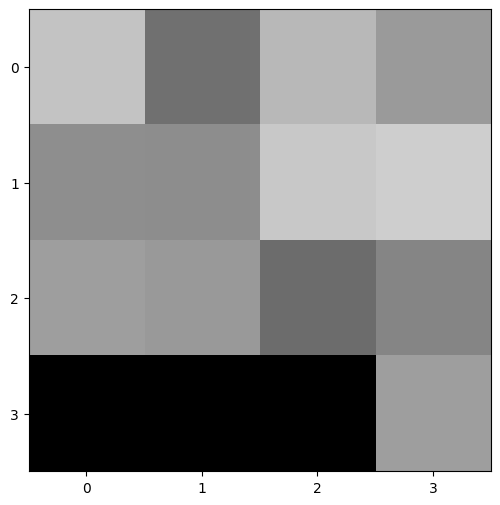

In [37]:
images, labels = generate_dataset_vh(100, (n, n, 1))
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[15]
print(f"Label: {['horizontal', 'vertical'][(labels[15] + 1) // 2]}")
print(f"Horizontal: {labels.count(-1)}; Vertical: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

[[  0   0   0   0]
 [  0  28  94   0]
 [  4  51 137   0]
 [  0   0   0   0]]
Label: nine
One: 64; Nine: 56


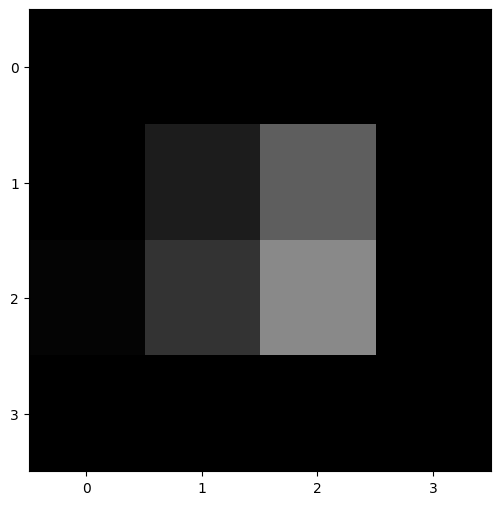

In [49]:
images, labels = get_mnist_data((1, 9), 120)
for i, l in enumerate(labels):
    if l == 1:
        labels[i] = -1
    else:
        labels[i] = 1
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[18]
print(image)
print(f"Label: {['one', 'nine'][(labels[18] + 1) // 2]}")
print(f"One: {labels.count(-1)}; Nine: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

In [31]:
def create_classifier_circuit(num_qubits, append_ansatz: bool=False) -> Tuple[QuantumCircuit, List[Parameter], List[Parameter]]:
    qc = QuantumCircuit(num_qubits)
    params = []
    for i in range(num_qubits):
        theta = Parameter(f"theta[{i}]")
        phi = Parameter(f"phi[{i}]")
        gate_x = RXGate(theta=theta)
        gate_z = RZGate(phi=phi)
        qc.append(gate_x, [i])
        qc.append(gate_z, [i])
        params.append(theta)
        params.append(phi)
    ansatz_qc = QuantumCircuit(num_qubits)
    if append_ansatz:
        ans_theta = Parameter(f"ans_theta")
        ans_phi = Parameter(f"ans_phi")
        ansatz_qc.append(
            TwoLocal(
                num_qubits=num_qubits,
                rotation_blocks=[RYGate(theta=ans_theta), RZGate(phi=ans_phi)],
                entanglement_blocks="crz",
                entanglement="linear",
                reps=1,
                insert_barriers=True,
                skip_final_rotation_layer=False,
                parameter_prefix=f"ansatz"
            ).decompose(),
            range(num_qubits)
        )
        qc.barrier()
        qc = qc.compose(
            ansatz_qc, range(num_qubits)
        )
    return qc, params, ansatz_qc.parameters

Original depth: 3, Transpiled depth: 92


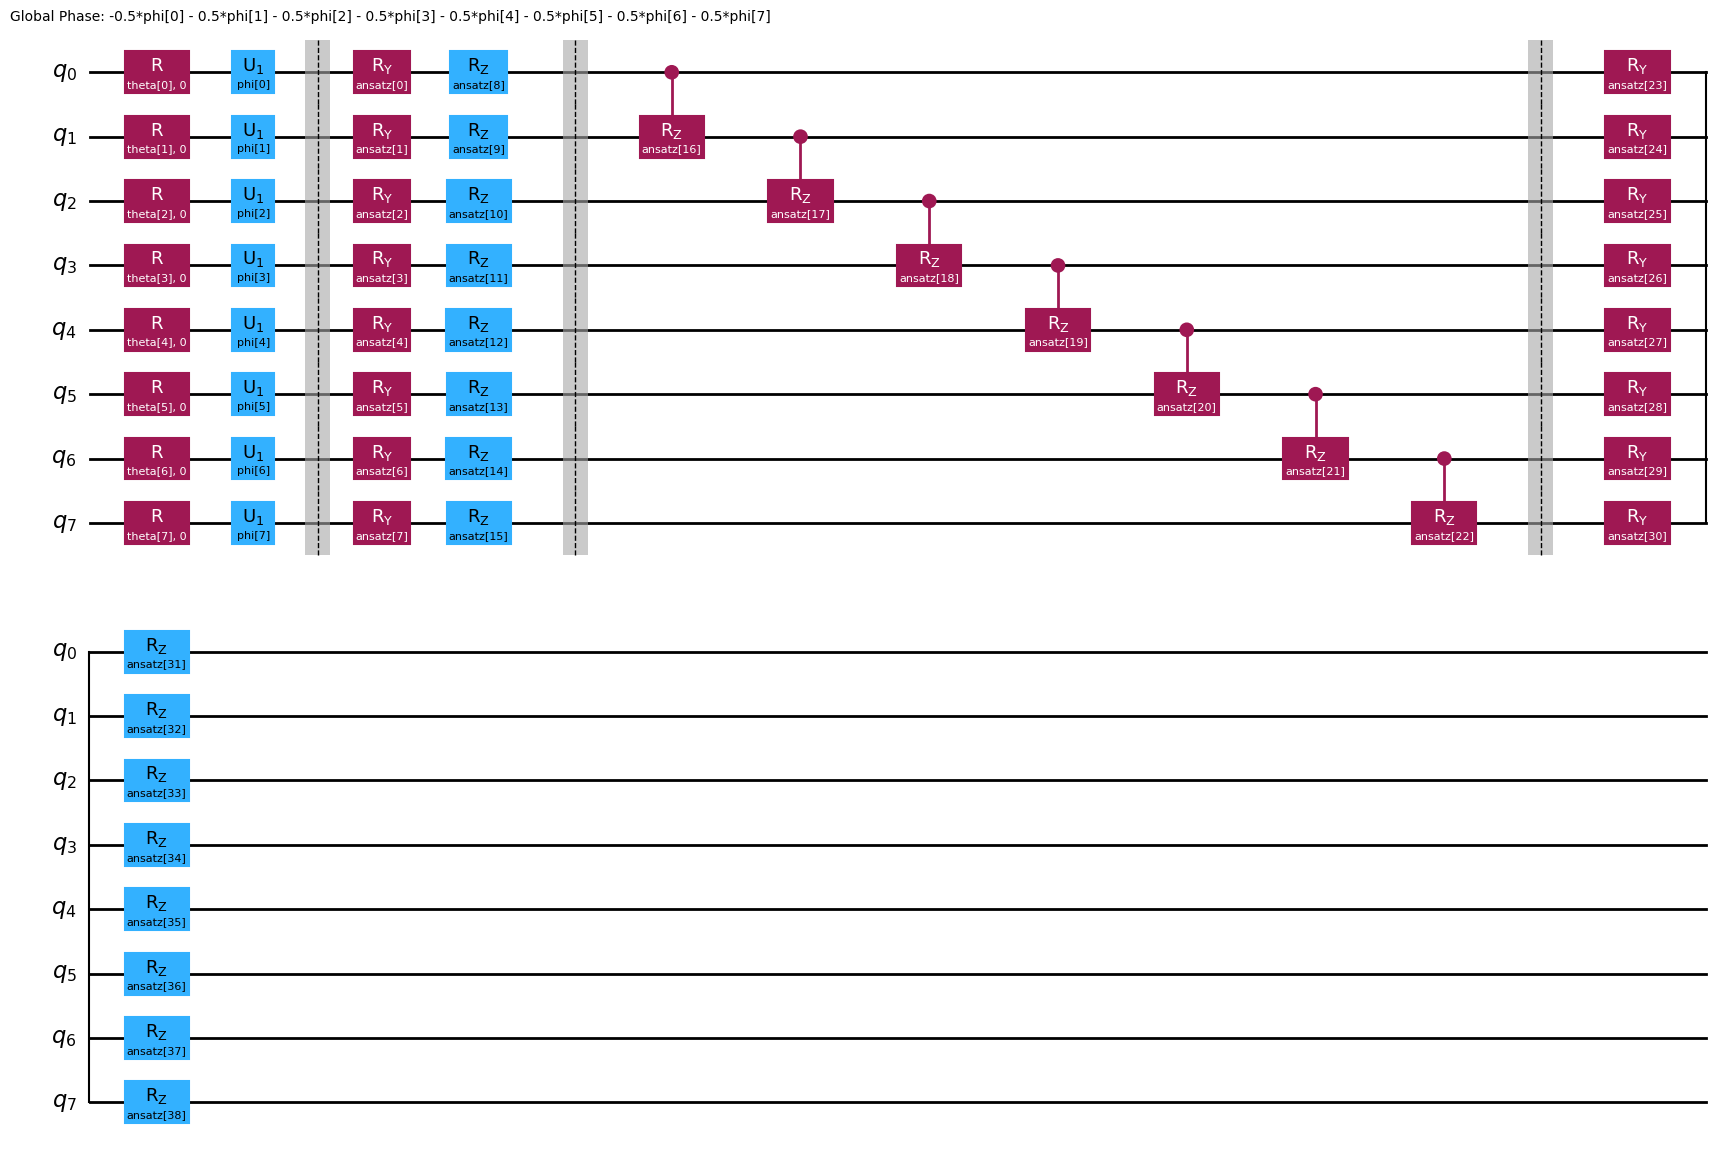

In [32]:
pqc, input_params, weight_params = create_classifier_circuit((n ** 2) // 2, append_ansatz=True)
print(f"Original depth: {pqc.depth()}, Transpiled depth: {transpiled_depth(pqc, 'ibm_kyoto')}")
pqc.decompose().draw("mpl", style="iqp")

In [33]:
arr = []
v = 0
for i in range(n):
    arr += [v] * (n // 2)
    # v = (v + 1) % 2
observables = [
    # SparsePauliOp.from_list([("Z" * (2 ** n), 1)]),
    build_interactions(np.array(arr).reshape((n, n // 2, 1))),
]
print(observables)

4 2
(0, 1) 0 0 4 2
(2, 3) 1 0 4 2
(4, 5) 2 0 4 2
(6, 7) 3 0 4 2
[SparsePauliOp(['ZZIIIIII', 'IIZZIIII', 'IIIIZZII', 'IIIIIIZZ', 'ZIZIIIII', 'IZIZIIII', 'IIZIZIII', 'IIIZIZII', 'IIIIZIZI', 'IIIIIZIZ', 'IZZIIIII', 'IIIZZIII', 'IIIIIZZI', 'ZIIZIIII', 'IIZIIZII', 'IIIIZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])]


In [34]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

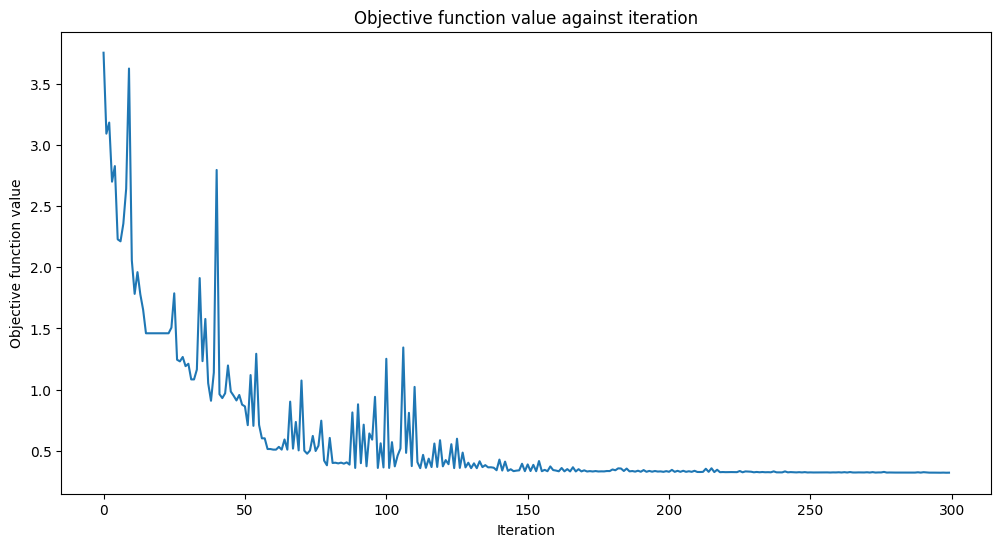

Accuracy from the train data : 89.58%


In [50]:
with Session(service=service, backend="ibm_osaka", max_time="12m") as session:
    estimator = None # Estimator(session=session)
    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=pqc.decompose(),
        observables=observables[0],
        input_params=input_params,
        weight_params=weight_params,
    )
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=300),  # Set max iterations here
        callback=callback_graph,
        #initial_point=np.ones(len(weight_params)),
        initial_point=np.random.random(len(weight_params)) * np.pi,
        #initial_point=classifier.weights,
    )
    x = np.asarray(train_images)
    y = np.asarray(train_labels)

    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    classifier.fit(x, y)

    # score classifier
    print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [51]:
print(classifier.weights)
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

[ 3.63260747  3.21178054  1.83903958  1.98438573  3.36888091  3.58365706
  0.06028747  1.27355541  3.21249078  1.15831334  2.71493594  1.68965675
  1.94656595  2.91699846  2.2354738  -0.28485515  2.68921786  2.08508552
  2.04600042  4.44215746 -0.53291745 -0.57548227  1.74200271  3.93179667
  1.67658121  1.93119838  2.95877263  2.40153734  1.38565361  1.32498997
  4.21717486  3.19070047  1.47990885  0.90779038  4.07052641 -0.12813798
  3.14779915  4.0405834   2.31391651]
Accuracy from the test data : 87.5%


In [ ]:
plt.imshow(images[0], cmap="gray")